In [1]:
import seaborn as sns
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt

# Load and Preview Data 

In [7]:
(body_fat := pl.read_csv('data/bodyfat.csv')).head(3)

shape: (3, 15)
┌─────────┬─────────┬─────┬────────┬───┬───────┬────────┬─────────┬───────┐
│ density ┆ bodyfat ┆ age ┆ weight ┆ … ┆ ankle ┆ biceps ┆ forearm ┆ wrist │
│ ---     ┆ ---     ┆ --- ┆ ---    ┆   ┆ ---   ┆ ---    ┆ ---     ┆ ---   │
│ f64     ┆ f64     ┆ i64 ┆ f64    ┆   ┆ f64   ┆ f64    ┆ f64     ┆ f64   │
╞═════════╪═════════╪═════╪════════╪═══╪═══════╪════════╪═════════╪═══════╡
│ 1.0708  ┆ 12.3    ┆ 23  ┆ 154.25 ┆ … ┆ 21.9  ┆ 32.0   ┆ 27.4    ┆ 17.1  │
│ 1.0853  ┆ 6.1     ┆ 22  ┆ 173.25 ┆ … ┆ 23.4  ┆ 30.5   ┆ 28.9    ┆ 18.2  │
│ 1.0414  ┆ 25.3    ┆ 22  ┆ 154.0  ┆ … ┆ 24.0  ┆ 28.8   ┆ 25.2    ┆ 16.6  │
└─────────┴─────────┴─────┴────────┴───┴───────┴────────┴─────────┴───────┘

In [ ]:
(ny_homes := pl.read_csv('data/Saratoga_NY_homes.csv')).head(3)

shape: (3, 17)
┌────────┬──────────┬────────────┬─────┬───┬────────────┬───────────┬───────┬─────────────┐
│ Price  ┆ Lot.Size ┆ Waterfront ┆ Age ┆ … ┆ Fireplaces ┆ Bathrooms ┆ Rooms ┆ Fireplaces? │
│ ---    ┆ ---      ┆ ---        ┆ --- ┆   ┆ ---        ┆ ---       ┆ ---   ┆ ---         │
│ i64    ┆ f64      ┆ i64        ┆ i64 ┆   ┆ i64        ┆ f64       ┆ i64   ┆ i64         │
╞════════╪══════════╪════════════╪═════╪═══╪════════════╪═══════════╪═══════╪═════════════╡
│ 132500 ┆ 0.09     ┆ 0          ┆ 42  ┆ … ┆ 1          ┆ 1.0       ┆ 5     ┆ 1           │
│ 181115 ┆ 0.92     ┆ 0          ┆ 0   ┆ … ┆ 0          ┆ 2.5       ┆ 6     ┆ 0           │
│ 109000 ┆ 0.19     ┆ 0          ┆ 133 ┆ … ┆ 1          ┆ 1.0       ┆ 8     ┆ 1           │
└────────┴──────────┴────────────┴─────┴───┴────────────┴───────────┴───────┴─────────────┘

# Analyzing Body Fat Predictors

#### Stack Predictors

In [16]:
(bodyfat_predictors :=
 body_fat
 .select(cs.by_name('bodyfat') | cs.float())
 .unpivot(cs.string(),
          index = 'bodyfat',
          variable_name = 'predictor',
          value_name = 'label')
 .to_pandas()
)

bodyfat predictor    label
0        12.3   density   1.0708
1         6.1   density   1.0853
2        25.3   density   1.0414
3        10.4   density   1.0751
4        28.7   density   1.0340
...       ...       ...      ...
3271     11.0     wrist  18.5000
3272     33.6     wrist  20.1000
3273     29.3     wrist  18.0000
3274     26.0     wrist  19.8000
3275     31.9     wrist  20.9000

[3276 rows x 3 columns]

## Marginal Relationships: Numeric Predictors with Smoothers

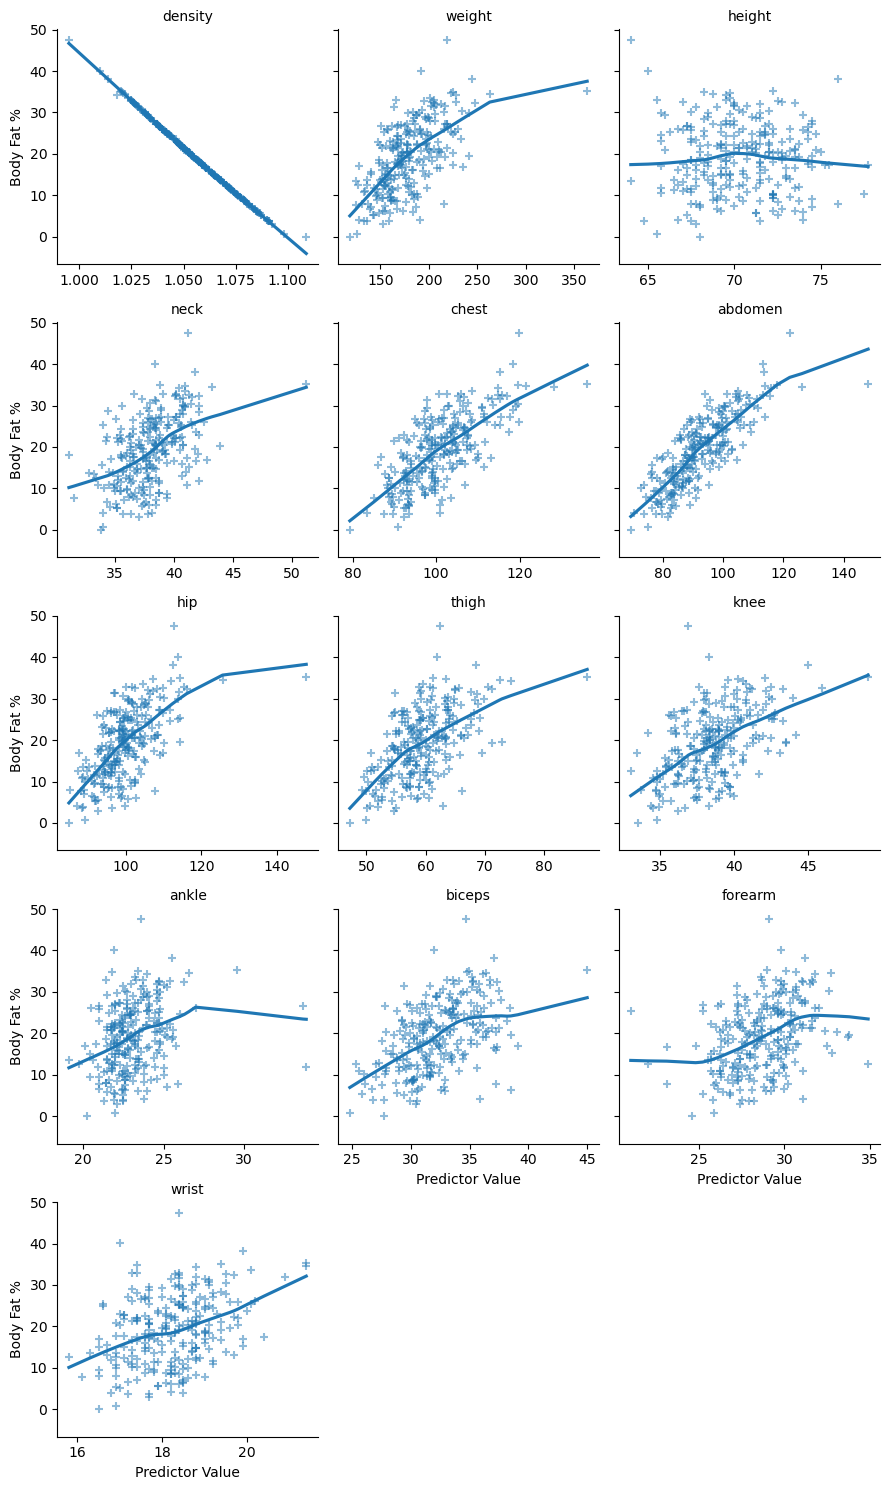

In [23]:
g = sns.FacetGrid(bodyfat_predictors, col='predictor', col_wrap=3, height=3, sharex=False)
g.map(sns.regplot, 'label', 'bodyfat', 
      lowess=True, 
      marker="+",
      scatter_kws={'alpha': 0.5})
g.set_axis_labels("Predictor Value", "Body Fat %")
g.set_titles("{col_name}")
plt.tight_layout()
plt.show()

#### Body fat percentage is strongly related to density (negative) and to weight and major body circumferences, especially abdomen, which stands out as the strongest predictor. Chest, hip, and thigh also show clear positive trends. Height and smaller limb measurements (ankle, wrist, forearm) show weak or minimal relationships and appear far less informative.

## Visualizing Joint Relationships

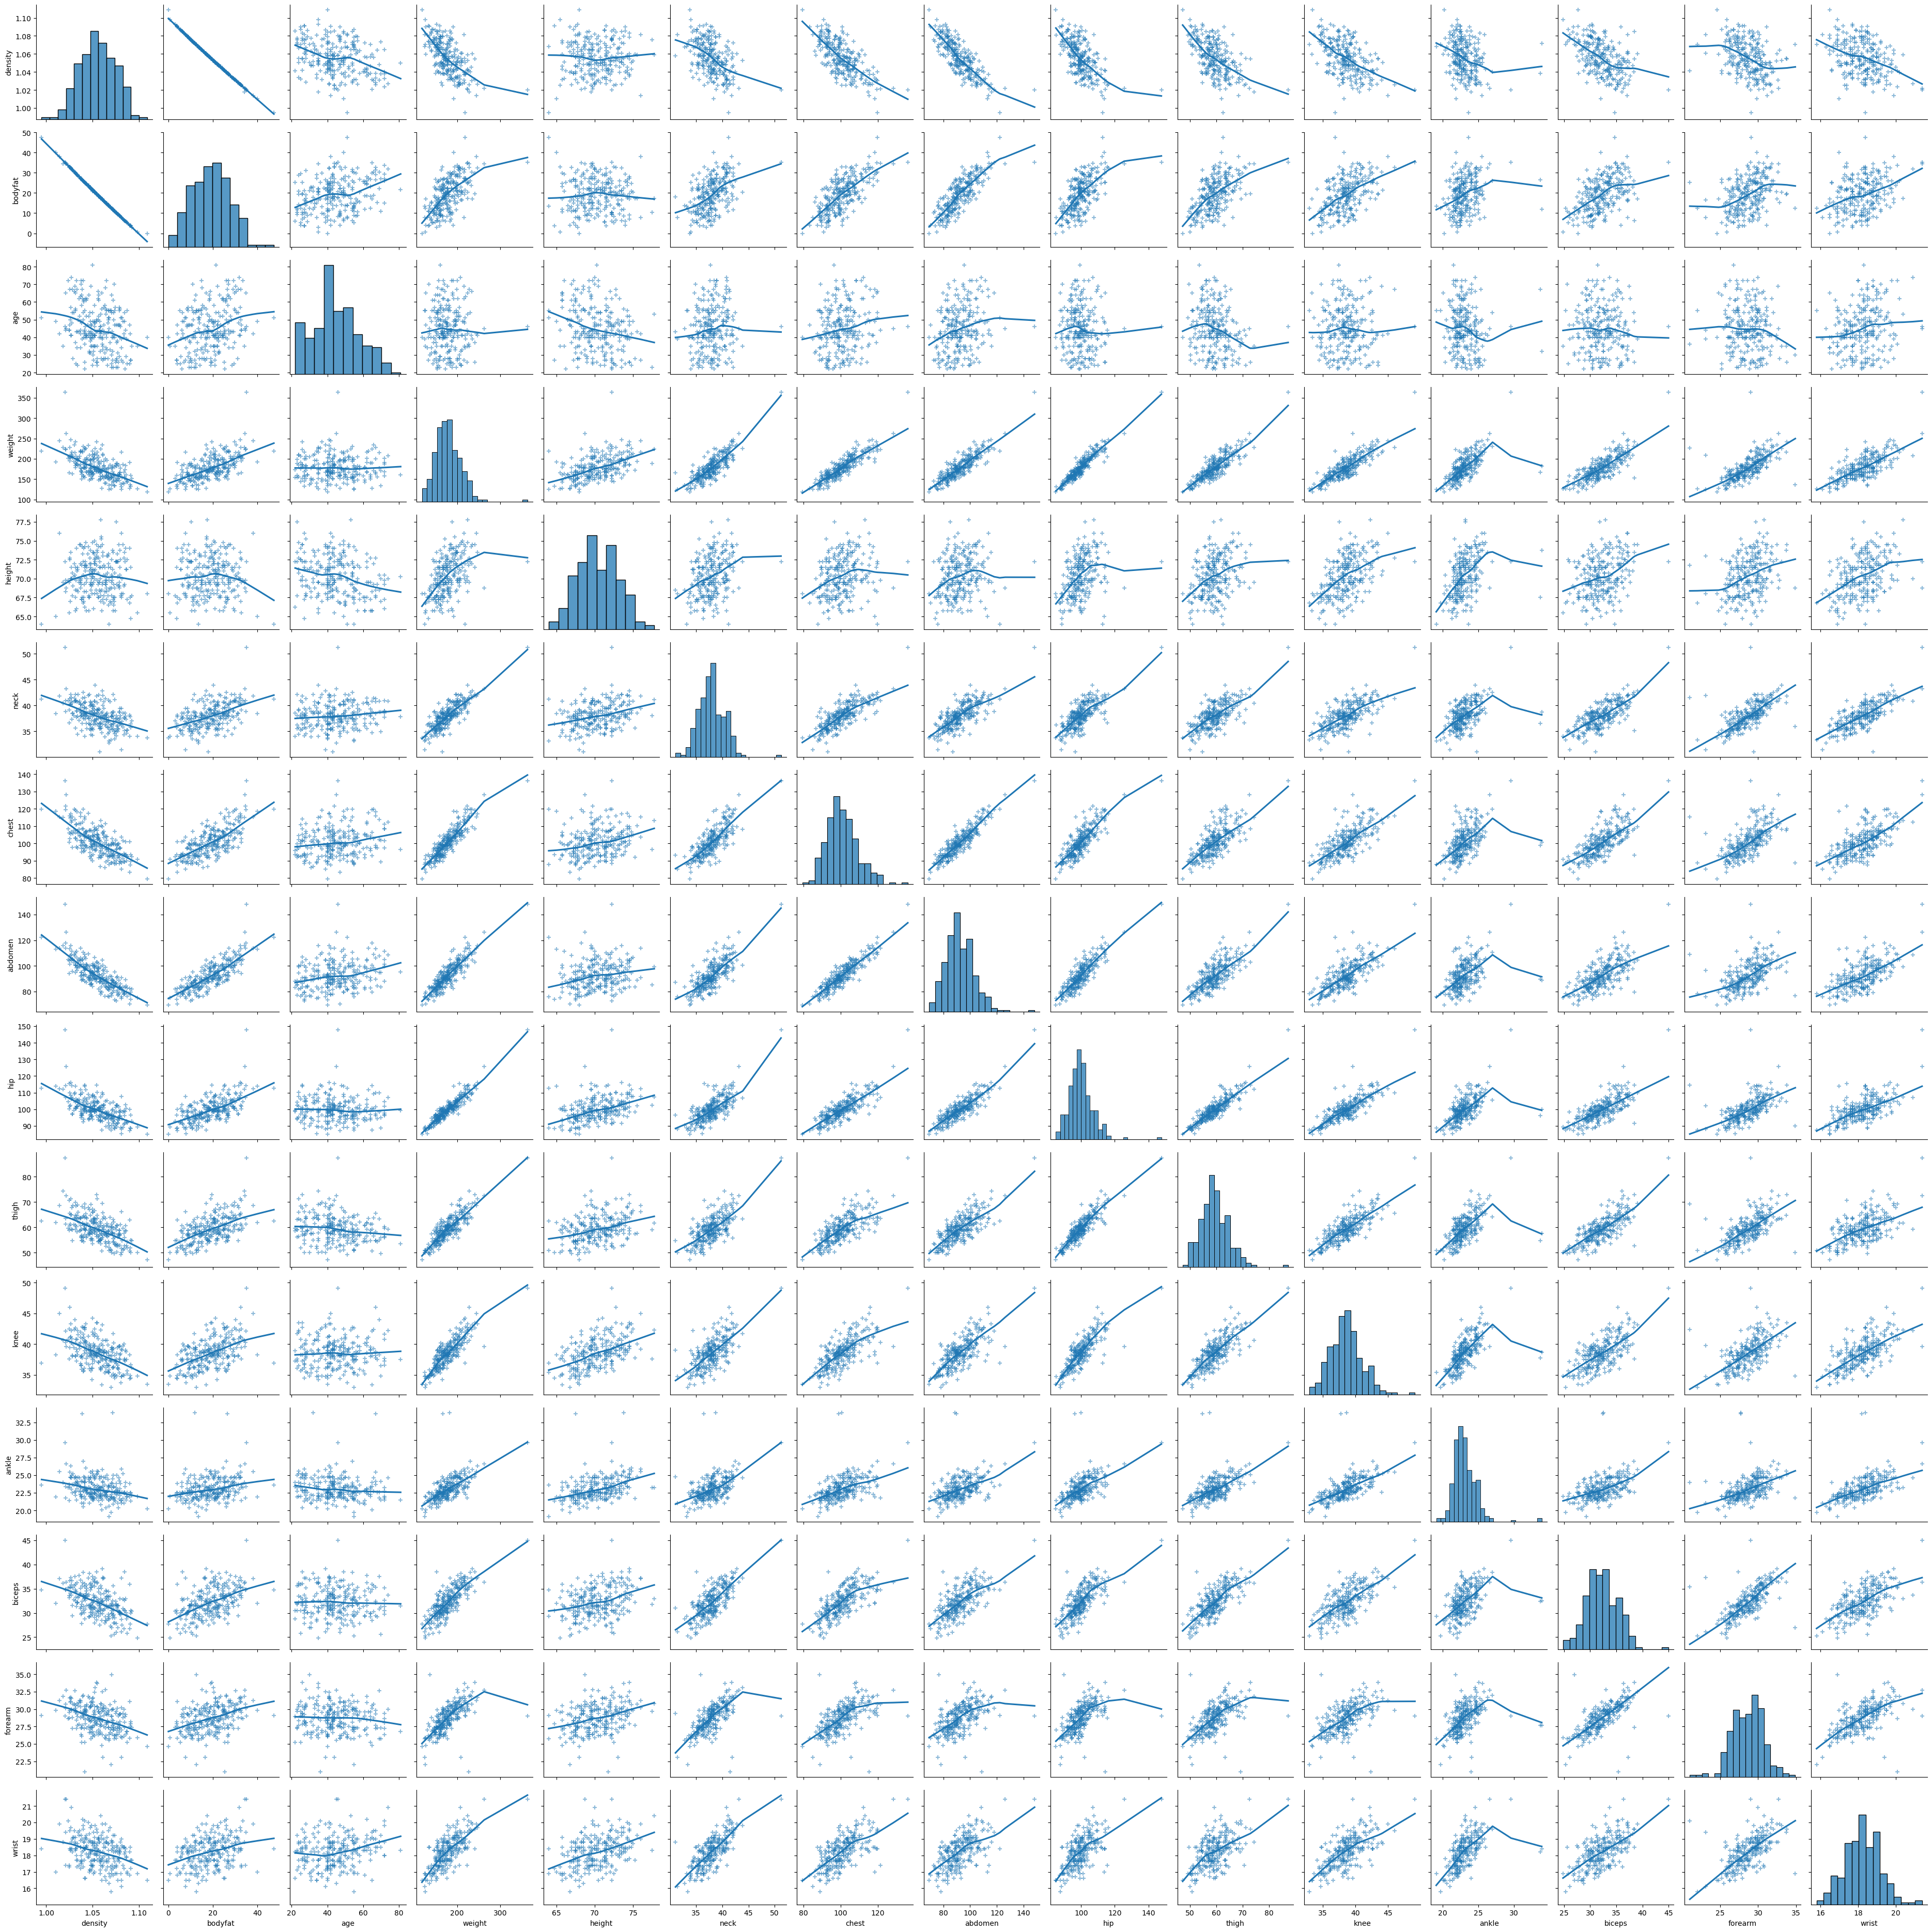

In [20]:
# Pairs plot with lowess smoother for all numeric predictors
g = sns.PairGrid(body_fat.to_pandas())
g.map_diag(sns.histplot)
g.map_offdiag(sns.regplot,
              lowess=True,
              marker="+",
              scatter_kws={'alpha': 0.5})
plt.tight_layout()
plt.show()

##### In the body fat row, body fat percentage shows strong positive relationships with weight, abdomen, chest, hip, and thigh, indicating these variables tend to increase together. It also has a very strong negative relationship with density, which clearly stands out from the rest. Height shows little to no relationship with body fat, and while slight curvature appears in some circumference-based relationships, the overall pattern suggests high multicollinearity, with many variables providing overlapping information about body fat.

# NY Homes Analyzing Predictors 

In [48]:
ny_homes.columns

['Price',
 'Lot.Size',
 'Waterfront',
 'Age',
 'Land.Value',
 'New.Construct',
 'Central.Air',
 'Fuel.Type',
 'Heat.Type',
 'Sewer.Type',
 'Living.Area',
 'Pct.College',
 'Bedrooms',
 'Fireplaces',
 'Bathrooms',
 'Rooms',
 'Fireplaces?']

In [53]:
# Recode column names: replace periods with spaces and remove Fireplaces? column
(ny_homes := ny_homes
 .rename({col: col.replace('.', ' ') for col in ny_homes.columns})
 .drop('Fireplaces?'))

shape: (1_728, 16)
┌────────┬──────────┬────────────┬─────┬───┬──────────┬────────────┬───────────┬───────┐
│ Price  ┆ Lot Size ┆ Waterfront ┆ Age ┆ … ┆ Bedrooms ┆ Fireplaces ┆ Bathrooms ┆ Rooms │
│ ---    ┆ ---      ┆ ---        ┆ --- ┆   ┆ ---      ┆ ---        ┆ ---       ┆ ---   │
│ i64    ┆ f64      ┆ i64        ┆ i64 ┆   ┆ i64      ┆ i64        ┆ f64       ┆ i64   │
╞════════╪══════════╪════════════╪═════╪═══╪══════════╪════════════╪═══════════╪═══════╡
│ 132500 ┆ 0.09     ┆ 0          ┆ 42  ┆ … ┆ 2        ┆ 1          ┆ 1.0       ┆ 5     │
│ 181115 ┆ 0.92     ┆ 0          ┆ 0   ┆ … ┆ 3        ┆ 0          ┆ 2.5       ┆ 6     │
│ 109000 ┆ 0.19     ┆ 0          ┆ 133 ┆ … ┆ 4        ┆ 1          ┆ 1.0       ┆ 8     │
│ 155000 ┆ 0.41     ┆ 0          ┆ 13  ┆ … ┆ 3        ┆ 1          ┆ 1.5       ┆ 5     │
│ 86060  ┆ 0.11     ┆ 0          ┆ 0   ┆ … ┆ 2        ┆ 0          ┆ 1.0       ┆ 3     │
│ …      ┆ …        ┆ …          ┆ …   ┆ … ┆ …        ┆ …          ┆ …         ┆ …     │
│ 289000 ┆ 0.38     ┆ 0          ┆ 32  ┆ … ┆ 5        ┆ 1          ┆ 2.5       ┆ 11    │
│ 285000 ┆ 0.94     ┆ 0          ┆ 37  ┆ … ┆ 4        ┆ 1          ┆ 2.5       ┆ 11    │
│ 194900 ┆ 0.39     ┆ 0          ┆ 9   ┆ … ┆ 2        ┆ 0          ┆ 1.0       ┆ 3     │
│ 125000 ┆ 0.24     ┆ 0          ┆ 48  ┆ … ┆ 3        ┆ 1          ┆ 1.0       ┆ 7     │
│ 111300 ┆ 0.59     ┆ 0          ┆ 86  ┆ … ┆ 3        ┆ 0          ┆ 1.0       ┆ 6     │
└────────┴──────────┴────────────┴─────┴───┴──────────┴────────────┴───────────┴───────┘

In [54]:
# Recode binary columns (0/1) to categorical labels
(ny_homes := ny_homes.with_columns([
    pl.when(pl.col(col) == 1).then(pl.lit('Yes'))
      .otherwise(pl.lit('No')).alias(col)
    for col in ['Waterfront', 'New Construct', 'Central Air', 'Fireplaces']
]))

shape: (1_728, 16)
┌────────┬──────────┬────────────┬─────┬───┬──────────┬────────────┬───────────┬───────┐
│ Price  ┆ Lot Size ┆ Waterfront ┆ Age ┆ … ┆ Bedrooms ┆ Fireplaces ┆ Bathrooms ┆ Rooms │
│ ---    ┆ ---      ┆ ---        ┆ --- ┆   ┆ ---      ┆ ---        ┆ ---       ┆ ---   │
│ i64    ┆ f64      ┆ str        ┆ i64 ┆   ┆ i64      ┆ str        ┆ f64       ┆ i64   │
╞════════╪══════════╪════════════╪═════╪═══╪══════════╪════════════╪═══════════╪═══════╡
│ 132500 ┆ 0.09     ┆ No         ┆ 42  ┆ … ┆ 2        ┆ Yes        ┆ 1.0       ┆ 5     │
│ 181115 ┆ 0.92     ┆ No         ┆ 0   ┆ … ┆ 3        ┆ No         ┆ 2.5       ┆ 6     │
│ 109000 ┆ 0.19     ┆ No         ┆ 133 ┆ … ┆ 4        ┆ Yes        ┆ 1.0       ┆ 8     │
│ 155000 ┆ 0.41     ┆ No         ┆ 13  ┆ … ┆ 3        ┆ Yes        ┆ 1.5       ┆ 5     │
│ 86060  ┆ 0.11     ┆ No         ┆ 0   ┆ … ┆ 2        ┆ No         ┆ 1.0       ┆ 3     │
│ …      ┆ …        ┆ …          ┆ …   ┆ … ┆ …        ┆ …          ┆ …         ┆ …     │
│ 289000 ┆ 0.38     ┆ No         ┆ 32  ┆ … ┆ 5        ┆ Yes        ┆ 2.5       ┆ 11    │
│ 285000 ┆ 0.94     ┆ No         ┆ 37  ┆ … ┆ 4        ┆ Yes        ┆ 2.5       ┆ 11    │
│ 194900 ┆ 0.39     ┆ No         ┆ 9   ┆ … ┆ 2        ┆ No         ┆ 1.0       ┆ 3     │
│ 125000 ┆ 0.24     ┆ No         ┆ 48  ┆ … ┆ 3        ┆ Yes        ┆ 1.0       ┆ 7     │
│ 111300 ┆ 0.59     ┆ No         ┆ 86  ┆ … ┆ 3        ┆ No         ┆ 1.0       ┆ 6     │
└────────┴──────────┴────────────┴─────┴───┴──────────┴────────────┴───────────┴───────┘

## Categorical Data Comparisons

#### Stack Categorical Predictors

In [55]:
(ny_cat_predictors :=
 ny_homes
 .select(cs.by_name('Price') | cs.string())
 .unpivot(cs.string(),
          index = 'Price',
          variable_name = 'predictor',
          value_name = 'label')
 .to_pandas()
)

Price   predictor label
0     132500  Waterfront    No
1     181115  Waterfront    No
2     109000  Waterfront    No
3     155000  Waterfront    No
4      86060  Waterfront    No
...      ...         ...   ...
6907  289000  Fireplaces   Yes
6908  285000  Fireplaces   Yes
6909  194900  Fireplaces    No
6910  125000  Fireplaces   Yes
6911  111300  Fireplaces    No

[6912 rows x 3 columns]

## Marginal Relationships: Categorical Predictors

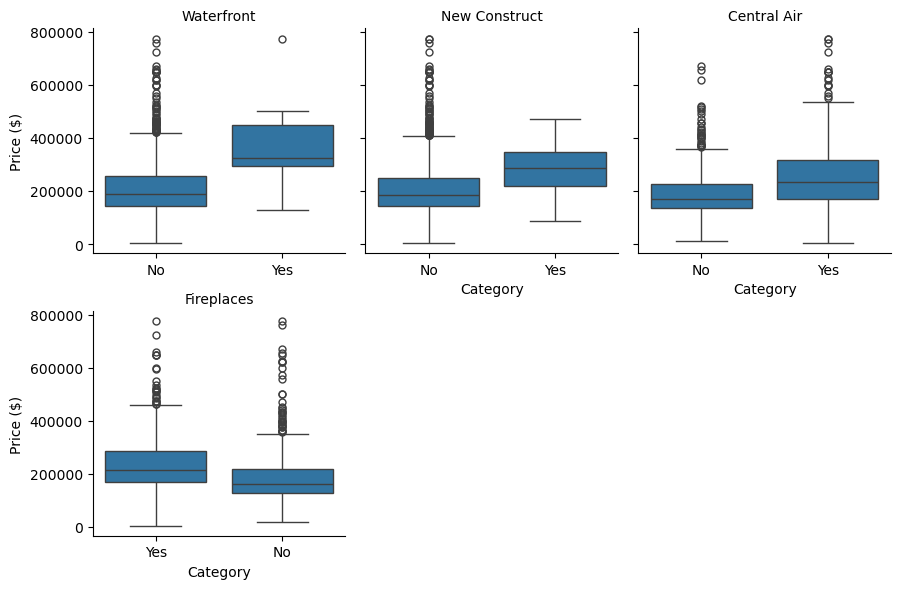

In [67]:
g = sns.catplot(
    data=ny_cat_predictors, x='label', y='Price',
    col='predictor', kind='box', col_wrap=3,
    height=3, sharex=False
)
g.set_axis_labels("Category", "Price ($)")
g.set_titles("{col_name}")
plt.tight_layout()
plt.show()

##### Among categorical predictors, waterfront homes command substantially higher prices with less variability compared to non-waterfront properties, showing the strongest marginal relationship. New construction, central air, and fireplaces all show positive associations with price, though with considerable overlap in their distributions. Heat type, fuel type, and sewer type exhibit relatively small differences between categories, suggesting these features have minimal impact on home prices in this market.

## Numeric Predictors Analysis

#### Stack Numeric Predictors

In [57]:
(ny_num_predictors :=
 ny_homes
 .select(cs.by_name('Price') | cs.numeric())
 .unpivot(cs.numeric().exclude('Price'),
          index = 'Price',
          variable_name = 'predictor',
          value_name = 'value')
 .to_pandas()
)

Price predictor  value
0      132500  Lot Size   0.09
1      181115  Lot Size   0.92
2      109000  Lot Size   0.19
3      155000  Lot Size   0.41
4       86060  Lot Size   0.11
...       ...       ...    ...
19003  289000     Rooms  11.00
19004  285000     Rooms  11.00
19005  194900     Rooms   3.00
19006  125000     Rooms   7.00
19007  111300     Rooms   6.00

[19008 rows x 3 columns]

## Marginal Relationships: Numeric Predictors with Smoothers

c:\Users\kh6102sj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
c:\Users\kh6102sj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


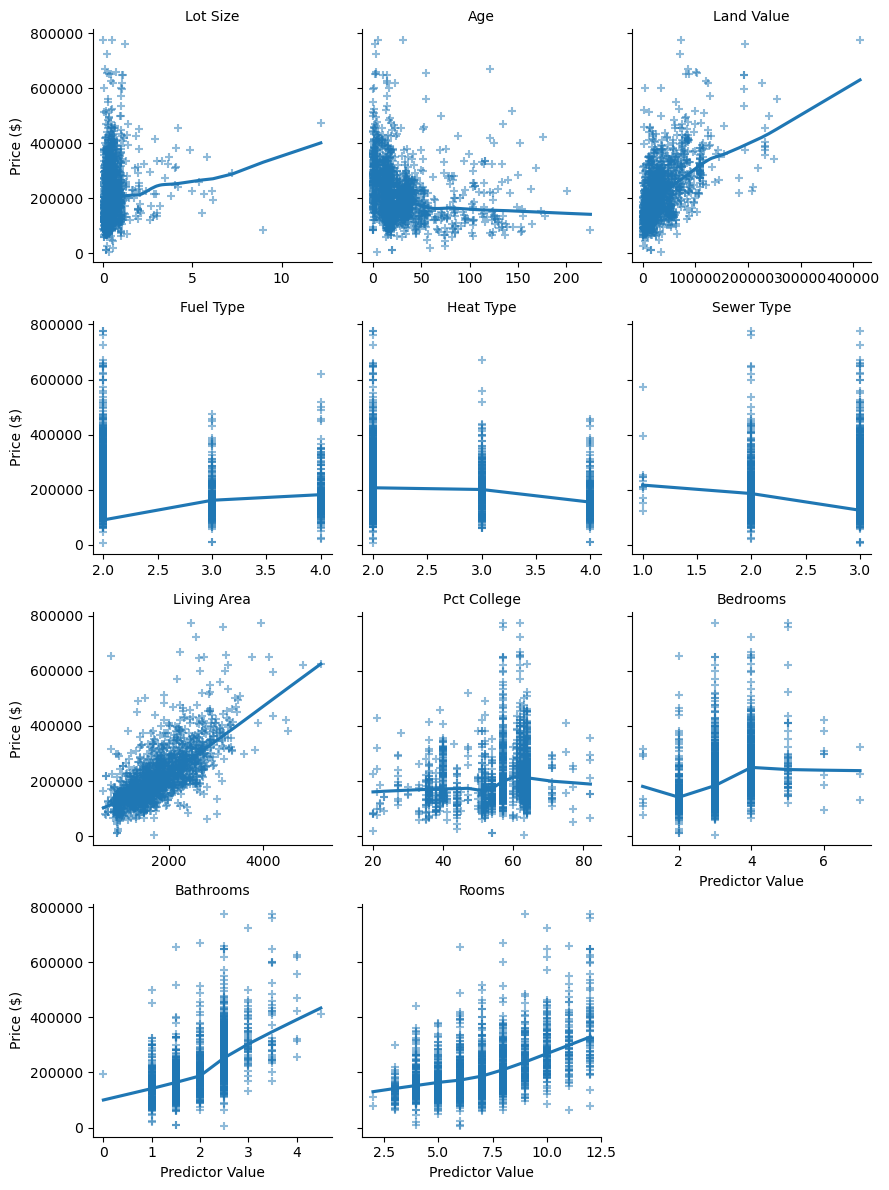

In [58]:
g = sns.FacetGrid(ny_num_predictors, col='predictor', col_wrap=3, height=3, sharex=False)
g.map(sns.regplot, 'value', 'Price', 
      lowess=True, 
      marker="+",
      scatter_kws={'alpha': 0.5})
g.set_axis_labels("Predictor Value", "Price ($)")
g.set_titles("{col_name}")
plt.tight_layout()
plt.show()

##### We see the most correlated relationship with price is living area followed by variables such as rooms, bathrooms, land value, and lot size have a weak positive relationship. The others show relatively no good relationship between them and price of NY Saratoga home

## Visualizing Joint Relationships: Pairs Plot

c:\Users\kh6102sj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
c:\Users\kh6102sj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
c:\Users\kh6102sj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
c:\Users\kh6102sj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
c:\Users\kh6102sj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:22

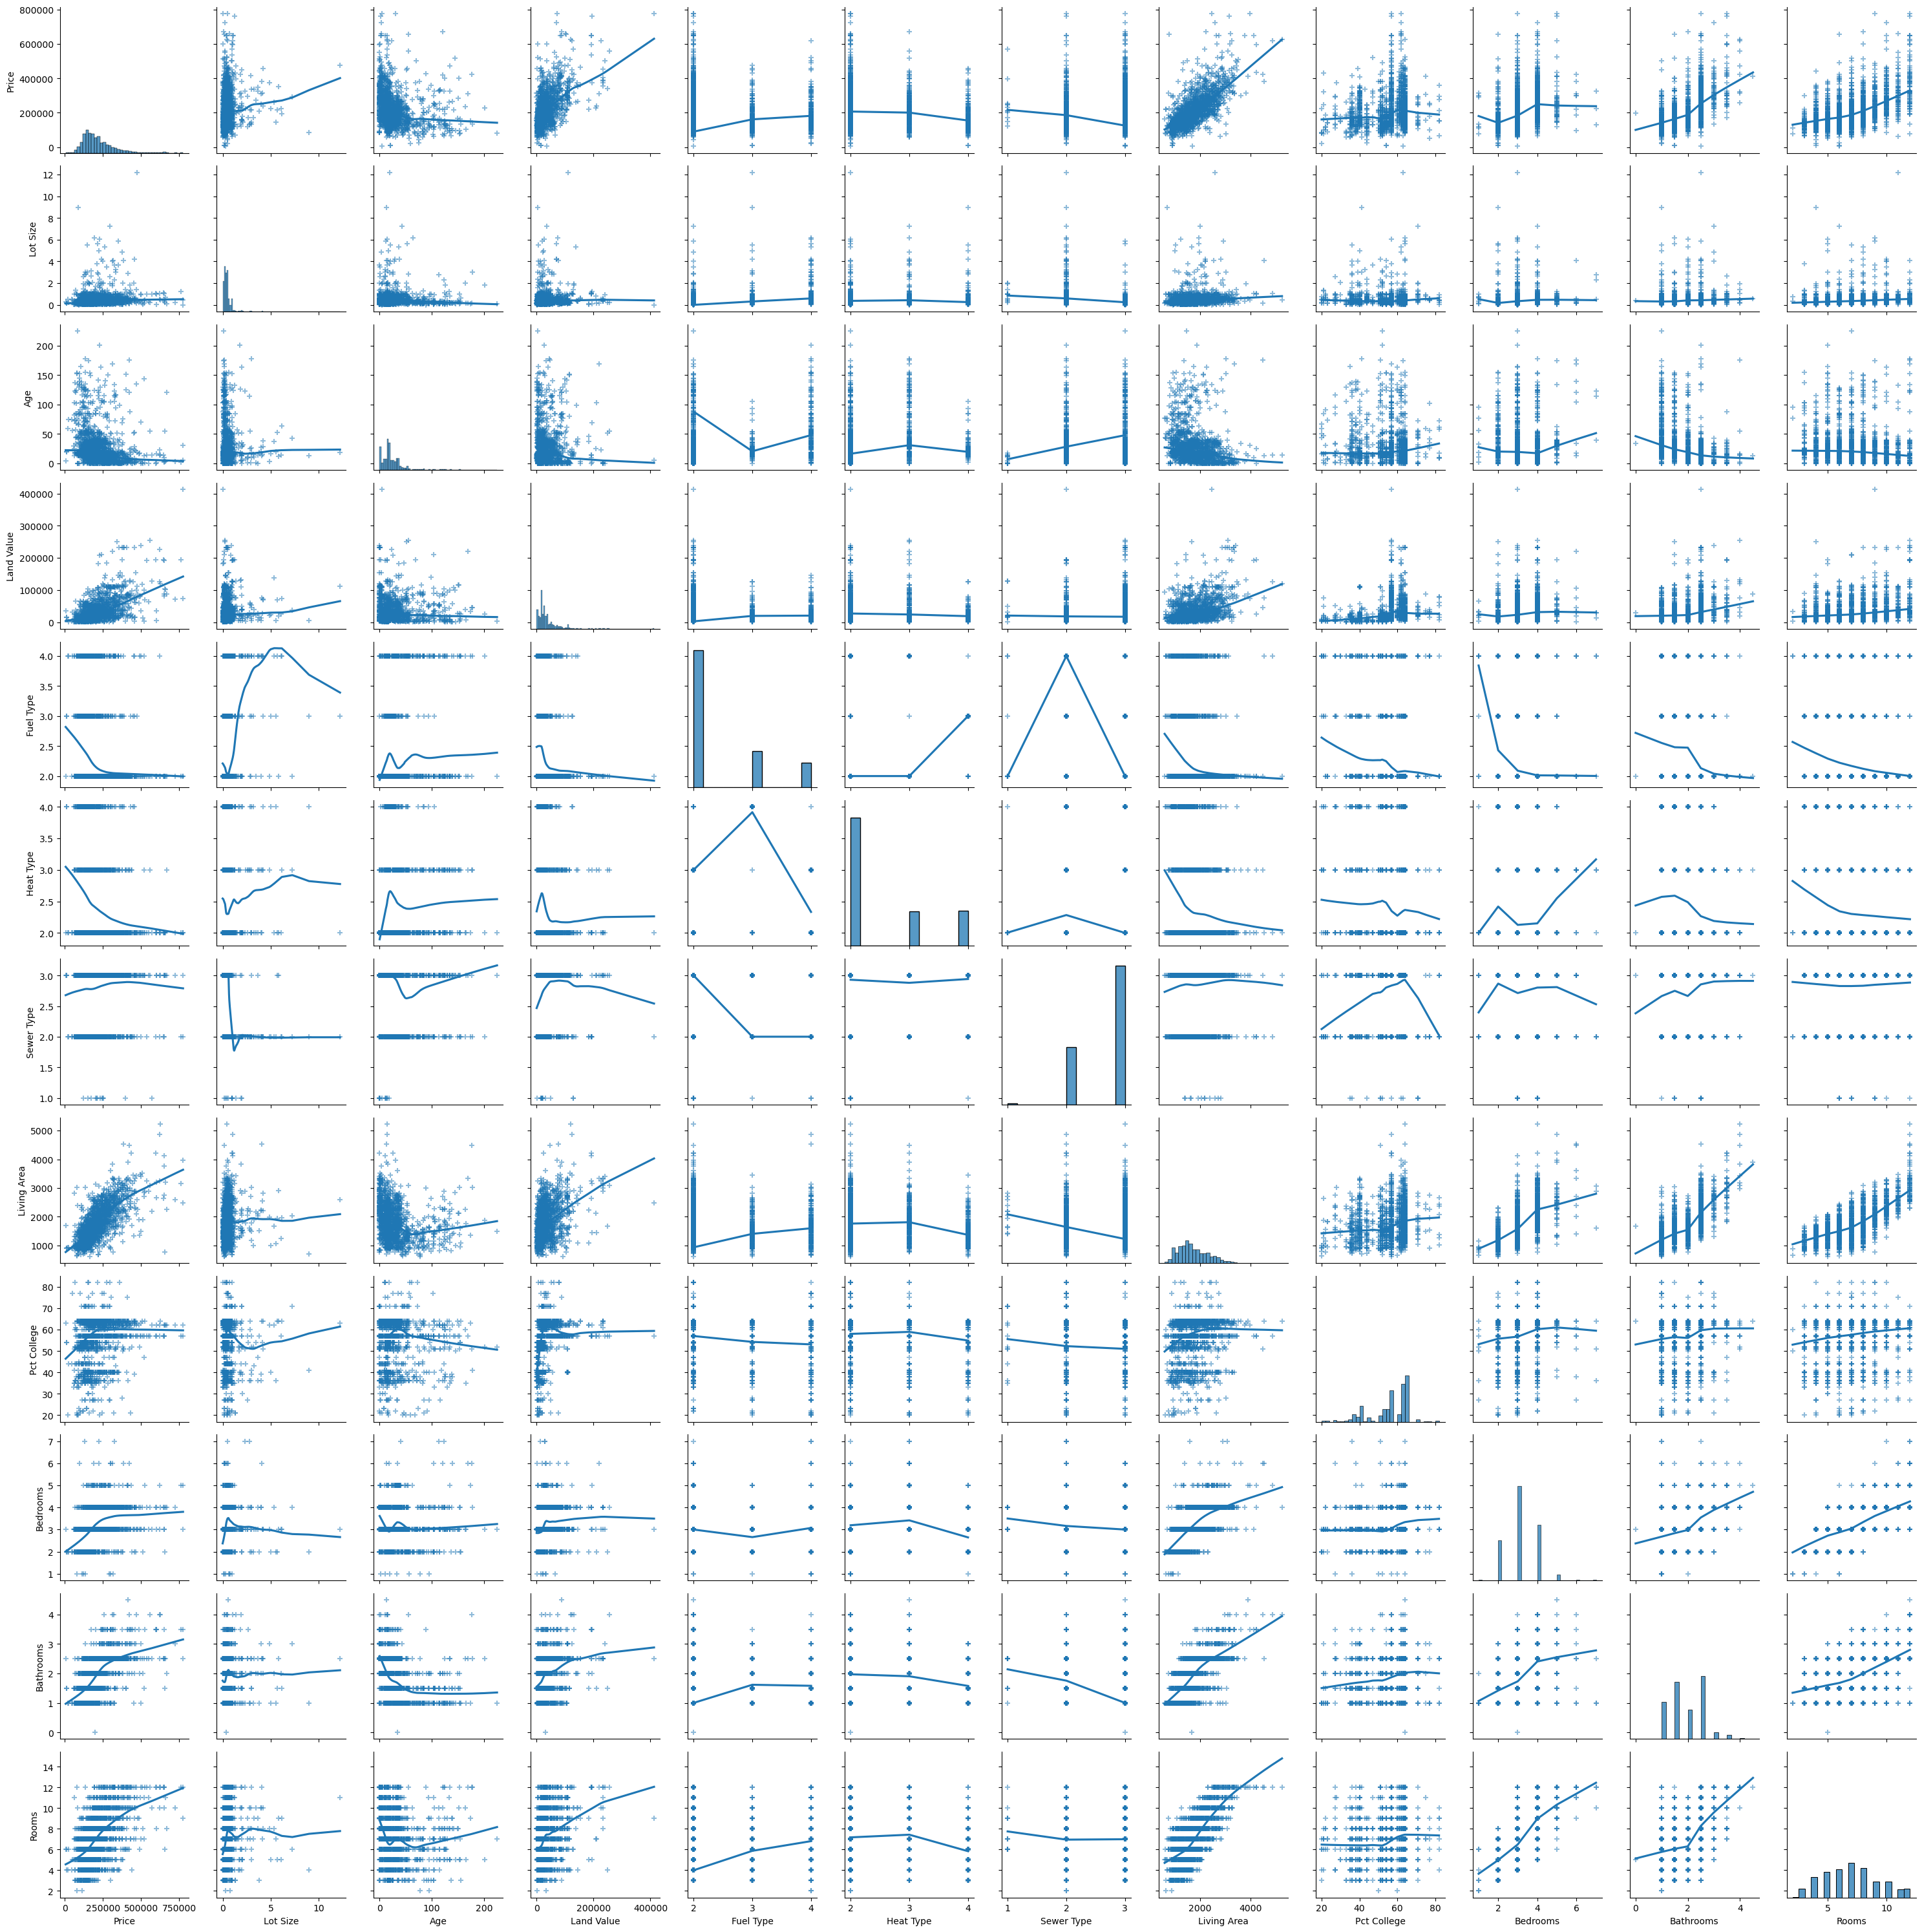

In [59]:
# Pairs plot with lowess smoother for all numeric predictors
g = sns.PairGrid(ny_homes.select(cs.numeric()).to_pandas())
g.map_diag(sns.histplot)
g.map_offdiag(sns.regplot,
              lowess=True,
              marker="+",
              scatter_kws={'alpha': 0.5})
plt.tight_layout()
plt.show()

##### Along the price row, price shows a strong positive relationship with living area, number of bedrooms, number of bathrooms, and total rooms, indicating that larger homes tend to cost more. Price also increases with higher quality and condition categories, though these relationships are more step-like due to categorical values. In contrast, price shows weak or inconsistent relationships with lot size, age, and neighborhood-related categorical variables, suggesting these factors have a smaller or less direct effect on price in this dataset.


## Joint Relationships: Living Area with Categorical Hues

Examining how Living Area relates to Price across different categorical variables.

### Living Area vs Price by Fuel Type

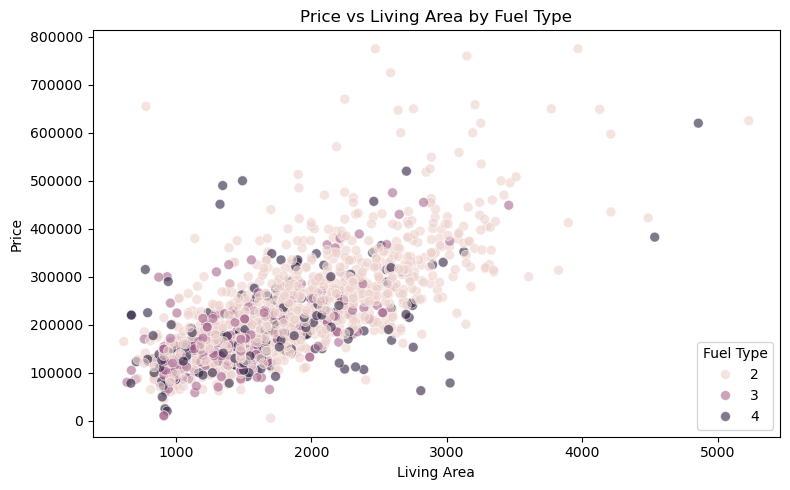

In [60]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=ny_homes.to_pandas(), x='Living Area', y='Price', 
                hue='Fuel Type', alpha=0.6, s=50)
plt.title('Price vs Living Area by Fuel Type')
plt.tight_layout()
plt.show()

#### When a house gets bigger or more expensive it is more likely to have fuel type 2

### Living Area vs Price by Heat Type

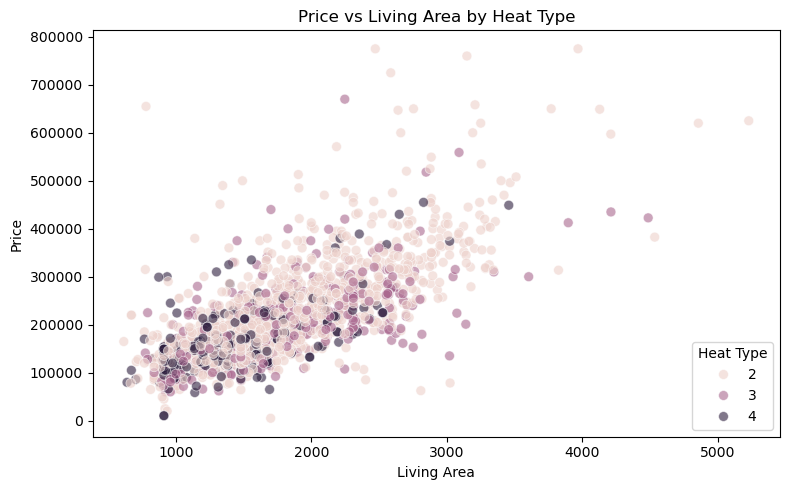

In [61]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=ny_homes.to_pandas(), x='Living Area', y='Price', 
                hue='Heat Type', alpha=0.6, s=50)
plt.title('Price vs Living Area by Heat Type')
plt.tight_layout()
plt.show()

#### We see a positive relationship with fuel type as if a house is more expensive/bigger it is more likely to have heat type 2

### Living Area vs Price by Sewer Type

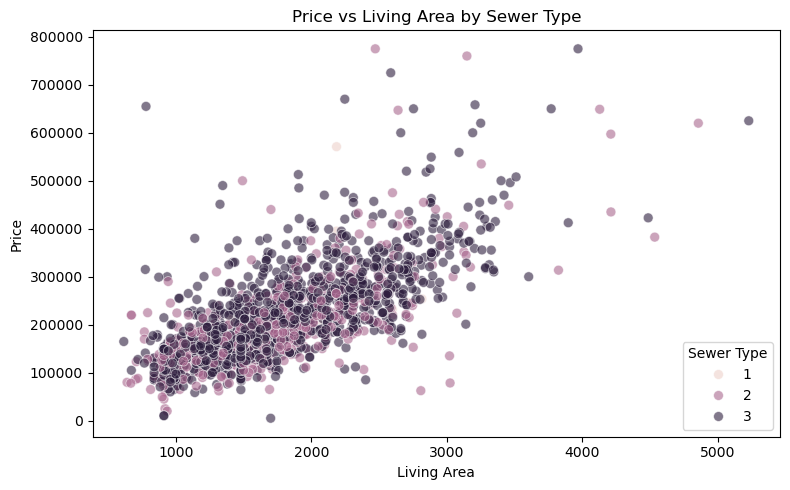

In [62]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=ny_homes.to_pandas(), x='Living Area', y='Price', 
                hue='Sewer Type', alpha=0.6, s=50)
plt.title('Price vs Living Area by Sewer Type')
plt.tight_layout()
plt.show()

#### There is a no relationship with which sewer type a house has with living area or price

### Living Area vs Price by Bedrooms

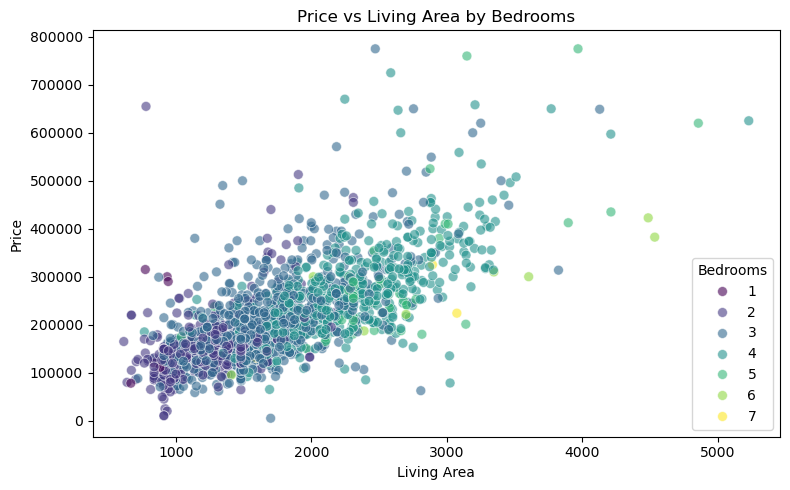

In [63]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=ny_homes.to_pandas(), x='Living Area', y='Price', 
                hue='Bedrooms', palette='viridis', alpha=0.6, s=50)
plt.title('Price vs Living Area by Bedrooms')
plt.tight_layout()
plt.show()

### Living Area vs Price by Bathrooms

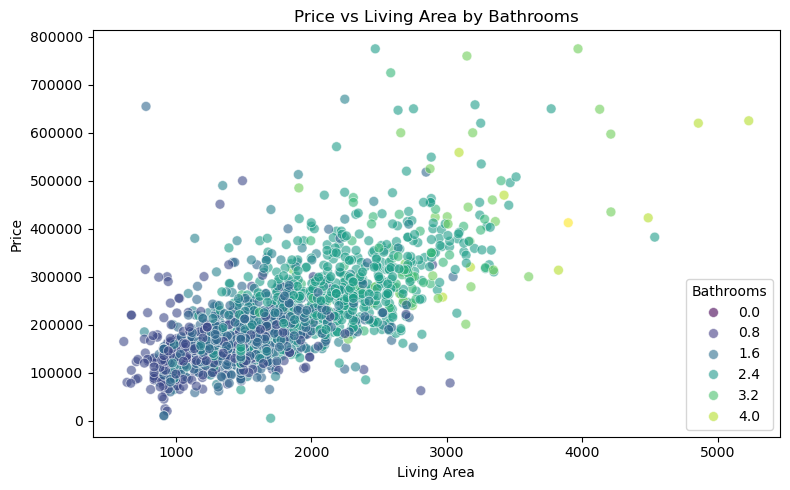

In [64]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=ny_homes.to_pandas(), x='Living Area', y='Price', 
                hue='Bathrooms', palette='viridis', alpha=0.6, s=50)
plt.title('Price vs Living Area by Bathrooms')
plt.tight_layout()
plt.show()

#### Bedrooms/Bathroom Summary: To no surprise when bathroom or bedrooms go up they go up positively with house price